# TP02 - Fundamentals of Artificial Intelligence


## Dataset

The dataset used for this project is a dataset from Kaggle that includes key tourism and economic indicators for over 200 countries between the years of 1999 and 2023.
Source Link to the dataset: https://www.kaggle.com/datasets/bushraqurban/tourism-and-economic-impact?select=world_tourism_economy_data.csv

### Description

### Dataset Metadata
Dataset name: world_tourism_economy_data.csv

Dataset strucure:
- country: The name of the country for which the data is reported.
- country_code: ISO country code (e.g., USA).
- year: The year for which the data is reported (1999-2023).
- tourism_receipts: Income from international tourism (in current US dollars).
- tourism_arrivals: Number of international tourists arriving in the country.
- tourism_exports: Share of exports derived from international tourism receipts (%).
- tourism_departures: Number of residents traveling abroad for tourism.
- tourism_expenditures: Spending by international tourists (in current US dollars).
- gdp: Gross Domestic Product of the country (in current US dollars).
- inflation: Annual percentage change in the price level (inflation).
- unemployment: Percentage of the labor force that is unemployed but actively seeking work.

Dataset row example:
`Portugal,PRT,2019,24592000000.0,17283000.0,23.4554217784929,3100000.0,6.6236680370026,240115970063.019,0.338178410046034,6.464 `

## Initial Imports and file read

In [2]:
%pip install pandas scikit-learn mlxtend matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt

# Loads the dataset
file_path = 'world_tourism_economy_data.csv'  # Replace with the actual path
tourism_data = pd.read_csv(file_path)

## Data Prepararion


In [4]:
# Create a new feature: Tourism GDP Percentage
# Assuming 'tourism_receipts' is equivalent to 'Tourism GDP'
tourism_data['Tourism_GDP_Percentage'] = (tourism_data['tourism_receipts'] / tourism_data['gdp']) * 100

# Create a binary target variable: High Tourism Impact
threshold = 5  # Adjust threshold as needed
tourism_data['High_Tourism_Impact'] = tourism_data['Tourism_GDP_Percentage'] > threshold

# Handle missing values (drop rows with missing required columns)
tourism_data = tourism_data.dropna(subset=['tourism_receipts', 'gdp', 'tourism_arrivals'])

# Inspect the dataset
print(tourism_data.head())

                       country country_code  year  tourism_receipts  \
0                        Aruba          ABW  1999      7.820000e+08   
1  Africa Eastern and Southern          AFE  1999      8.034209e+09   
3   Africa Western and Central          AFW  1999      1.443613e+09   
4                       Angola          AGO  1999      3.100000e+07   
5                      Albania          ALB  1999      2.180000e+08   

   tourism_arrivals  tourism_exports  tourism_departures  \
0      9.720000e+05        62.542949                 NaN   
1      1.530938e+07        12.204030                 NaN   
3      3.897975e+06         3.974476                 NaN   
4      4.500000e+04         0.583858                 NaN   
5      3.710000e+05        55.969191                 NaN   

   tourism_expenditures           gdp   inflation  unemployment  \
0              9.495387  1.722905e+09    2.280372           NaN   
1              7.760536  2.654293e+11    7.819865           NaN   
3          

## Decision Tree Classification

Decision Tree Accuracy: 0.88


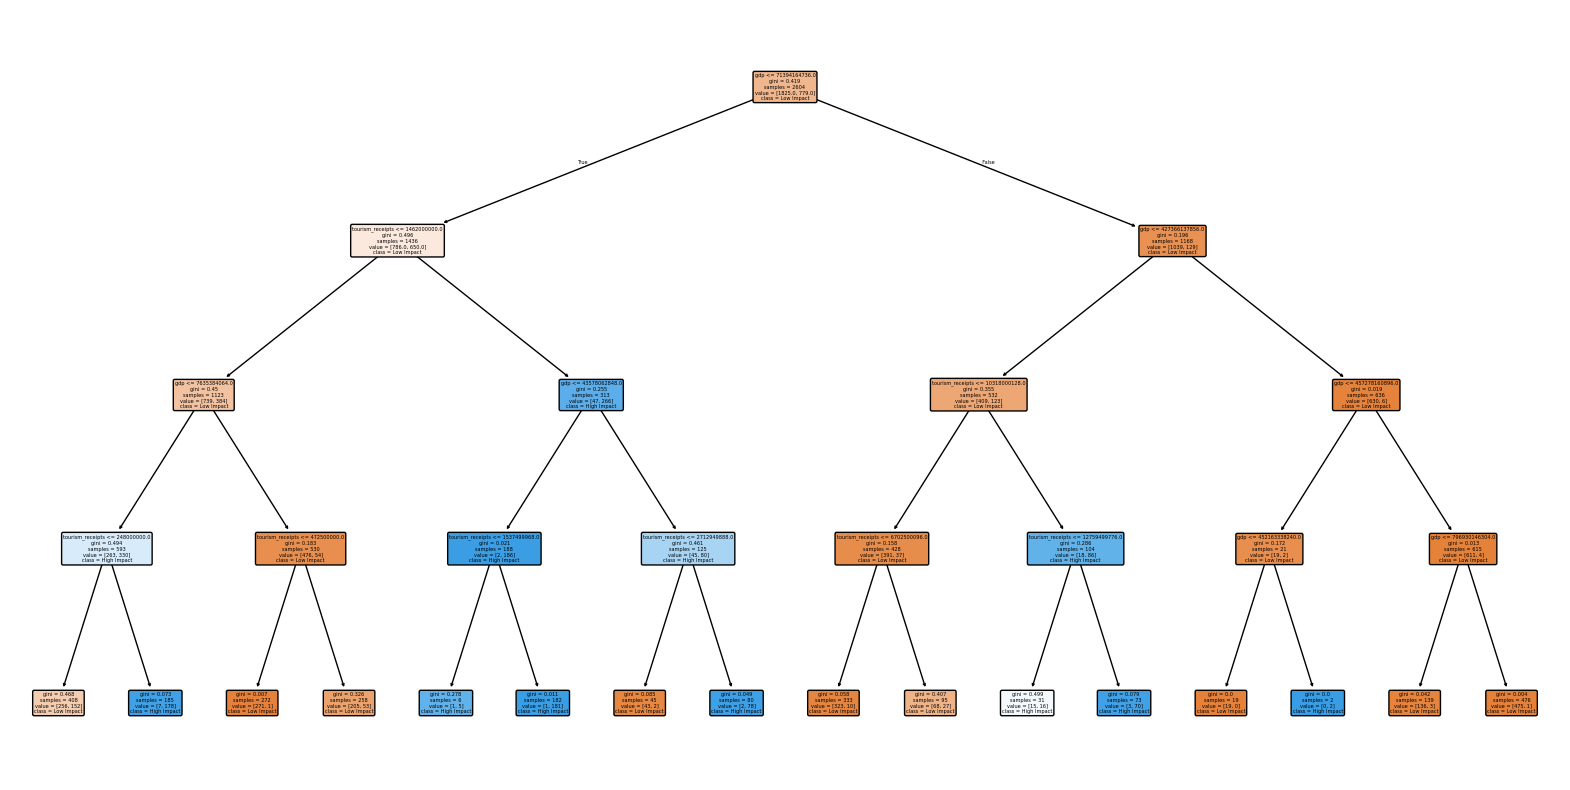

In [5]:
# Prepare features and target
X = tourism_data[['tourism_arrivals', 'tourism_receipts', 'gdp']]  # Relevant columns
y = tourism_data['High_Tourism_Impact']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Train the Decision Tree Classifier
clf = DecisionTreeClassifier(random_state=1234, max_depth=4)
clf_model = clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {accuracy:.2f}")

# Visualize the decision tree
plt.figure(figsize=(20, 10))
plot_tree(clf_model, filled=True, rounded=True, feature_names=X.columns, class_names=['Low Impact', 'High Impact'])
plt.show()

## Clustering

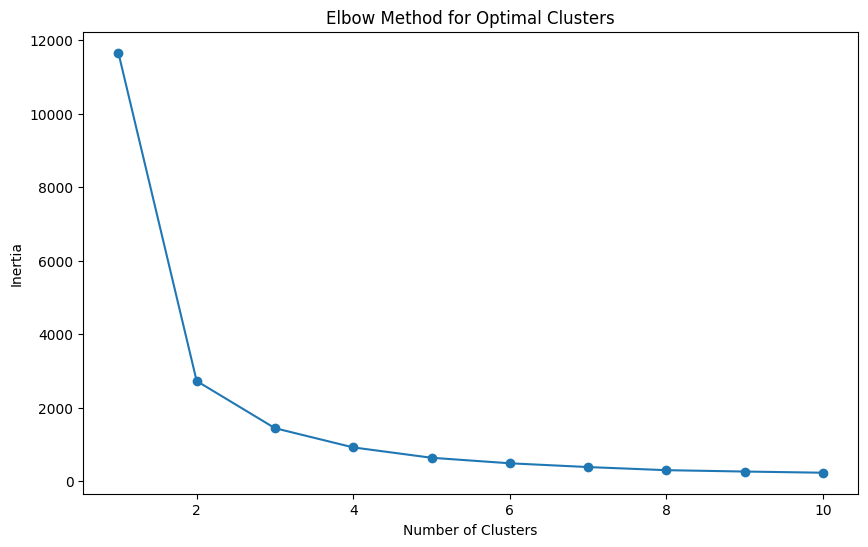

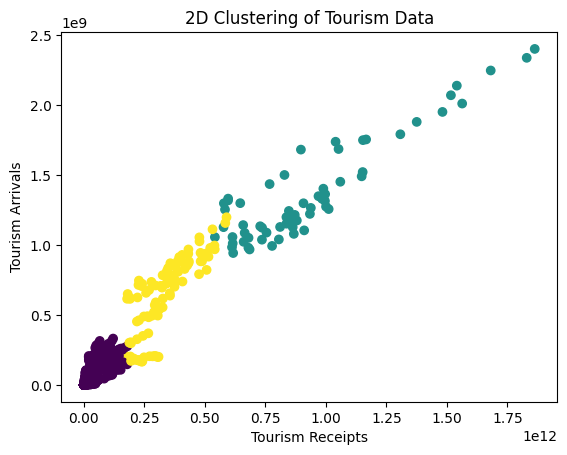

In [6]:
# Select features for clustering
features = tourism_data[['tourism_arrivals', 'tourism_receipts', 'gdp']]

# Standardize the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Determine the optimal number of clusters using the elbow method
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.show()

# Perform clustering
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(scaled_features)

# Add cluster labels to the dataset
tourism_data['Cluster'] = clusters

# Visualize the clusters in 2D
plt.scatter(features['tourism_receipts'], features['tourism_arrivals'], c=clusters, cmap='viridis', marker='o')
plt.xlabel('Tourism Receipts')
plt.ylabel('Tourism Arrivals')
plt.title('2D Clustering of Tourism Data')
plt.show()

## Association Rule Mining

In [19]:
# Simulate a region or group-based transaction dataset
# If no 'Region' column exists, create a proxy using country and year
tourism_data['Region'] = tourism_data['country'] + '_' + tourism_data['year'].astype(str)

region_group = tourism_data.groupby('Region')['High_Tourism_Impact'].apply(lambda x: x.astype(str).tolist())


# Encode transactions
te = TransactionEncoder()
te_ary = te.fit(region_group).transform(region_group)
transaction_df = pd.DataFrame(te_ary, columns=te.columns_)

true_rows = tourism_data[tourism_data['High_Tourism_Impact'] == True]
print(true_rows)

# Apply Apriori
frequent_itemsets = apriori(transaction_df, min_support=0.1, use_colnames=True)
rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=0.5, num_itemsets=10)

# Display some rules
print(rules[['antecedents', 'consequents', 'support', 'confidence']])

# Example rule prediction
def predict_tourism_impact(rules_df, region):
    for _, row in rules_df.iterrows():
        print(row['antecedents'])
        if region in row['antecedents']:
            print(f"Association found: {row['antecedents']} -> {row['consequents']}")
            return
    print(f"No specific association rule found for {region}.")

predict_tourism_impact(rules, 'Maldives_2020')

                    country country_code  year  tourism_receipts  \
0                     Aruba          ABW  1999      7.820000e+08   
5                   Albania          ALB  1999      2.180000e+08   
14                  Austria          AUT  1999      1.235800e+10   
21                 Bulgaria          BGR  1999      1.184000e+09   
22                  Bahrain          BHR  1999      7.850000e+08   
...                     ...          ...   ...               ...   
5738               Maldives          MDV  2020      1.409000e+09   
5786                  Qatar          QAT  2020      1.431800e+10   
5812             Seychelles          SYC  2020      2.280000e+08   
5842  Virgin Islands (U.S.)          VIR  2020      6.860000e+08   
5844                Vanuatu          VUT  2020      6.700000e+07   

      tourism_arrivals  tourism_exports  tourism_departures  \
0         9.720000e+05        62.542949                 NaN   
5         3.710000e+05        55.969191                 N